In [2]:
%load_ext autoreload
%autoreload 2
from functools import partial
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pyro.distributions as dist
import torch

from dotenv import dotenv_values
from scipy import stats
from torch import Tensor

from bayesian_stats.mcmc import ParameterSamples, run_mcmc
from bayesian_stats.utils import get_cumulative_prob, get_quantile_diffs, get_wasserstein_distance

# Beta-binomial example
What is the probability a coin is materially biases towards heads ($P(heads) > 52.5\%$), given we flipped it 250 times and observed 140 heads?

We'll set our prior to convey significant skepticism the coin is biased: $P(heads) \sim beta(a=100, b=100)$

## Analytic solution using beta-binomial conjugate

In [ ]:
prior = stats.beta(a=100, b=100)
posterior = stats.beta(a=100 + 140, b=100 + 250 - 140)
print(f"P(heads) > 52.5% after observing 140 heads out of 250 flips: {1 - posterior.cdf(0.525):.2%}")

_, ax = plt.subplots(figsize=(10,5))

p_heads = torch.linspace(0, 1, 1001)
ax.plot(p_heads, prior.pdf(p_heads), label="prior", color="blue")
ax.plot(p_heads, posterior.pdf(p_heads), label="posterior", color="orange")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Distribution of latent probability this coin lands on heads after observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend();

## Approximate solution using MCMC

In [2]:
def prior_func(a: float, b: float, p: Tensor) -> Tensor:
    return dist.Beta(a, b).log_prob(p)

def likelihood_func(p: Tensor, n: int, k: int) -> Tensor:
    return dist.Binomial(total_count=n, probs=p).log_prob(torch.tensor(k))

parameter_samples = ParameterSamples.random_initialization(
    bounds=dict(p=(0., 1.)),
    shapes=dict(p=(1,)),
    num_samples=2**12,
)
result = run_mcmc(
    parameter_samples,
    prior_func=partial(prior_func, a=100, b=100),
    likelihood_func=partial(likelihood_func, n=250, k=140),
    max_iter=1_000,
    max_corr=0.01,
    max_split_distance=0.005,
    verbose=True,
)
result.get_posterior_summary()

,mean,std,min,25%,50%,75%,max
p,0.532834,0.02367,0.378193,0.517261,0.533207,0.549134,0.629403


### Diagnostic plots

In [ ]:
_, ax = plt.subplots(figsize=(10,5))
for param in result.parameter_samples.keys():
    ax.plot(result.correlation_traces[param].squeeze(), label=param)
ax.set_title("Correlation of samples with intialization", loc="left");
ax.set_xlabel("MCMC Iteration #");
ax.set_ylabel("Correlation");
ax.spines[['right', 'top']].set_visible(False);
ax.legend();

In [ ]:
_, ax = plt.subplots(figsize=(10,5))
for param in result.parameter_samples.keys():
    ax.plot(result.wasserstein_distance_traces[param].squeeze(), label=param)
ax.set_title("Trace of Wasserstein distance between split A & B", loc="left");
ax.set_xlabel("MCMC Iteration #");
ax.set_ylabel("Wasserstein Distance");
ax.spines[['right', 'top']].set_visible(False);
ax.legend();

### $P(heads) > 52.5\%$ using MCMC samples

In [ ]:
print(f"P(heads) > 52.5% after observing 140 heads out of 250 flips: {(result.parameter_samples['p'] > 0.525).numpy().mean():.2%}")

_, ax = plt.subplots(figsize=(10,5))

p_heads = torch.linspace(0, 1, 101)
ax.plot(p_heads, prior.pdf(p_heads), label="prior", color="blue")
ax.plot(p_heads, posterior.pdf(p_heads), label="posterior", color="orange")
ax.hist(result.parameter_samples["p"].squeeze(), bins=p_heads, density=True, label="approx-posterior", color="green", alpha=0.5)
ax.axvline(x=result.map_values["p"].item(), label="MAP estimate", color="green", linestyle="--")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Distribution of latent probability this coin lands on heads after observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend();

# Gamma-Poisson Example

You and your kid want to estimate how many pieces of candy, on average, a trick-or-treater collects from each house they visit. You both think the average is probably 2, but you also think there is a reasonable chance it could be materially higher than that. A $candy\_rate \sim Gamma(1, 0.5)$ is a reasonable reflection of your prior beliefs.

After visiting `5` houses, your kid has collected `[1, 6, 4, 2, 5]` pieces of candy; what's your updated belief of what the latent `candy_rate` is?

## Analytic solution using gamma-poisson conjugate

In [ ]:
prior = dist.Gamma(concentration=1, rate=0.5)
obs = [1, 6, 4, 2, 5]
posterior = dist.Gamma(concentration=1 + sum(obs), rate=0.5 + len(obs))

_, ax = plt.subplots(figsize=(10,5))

candy_rate = torch.linspace(0, 15, 1001)
ax.plot(candy_rate, torch.exp(prior.log_prob(candy_rate)), label="prior", color="blue")
ax.plot(candy_rate, torch.exp(posterior.log_prob(candy_rate)), label="posterior", color="orange")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Distribution of latent 'candy rate' after collecting 18 pieces in 5 houses",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend();

## Approximate solution using MCMC

In [ ]:
def prior_func(concentration: float, rate: float, candy_rate: Tensor) -> Tensor:
    return dist.Gamma(concentration, rate).log_prob(candy_rate)

def likelihood_func(candy_rate: Tensor, obs: list[int]) -> Tensor:
    return dist.Poisson(rate=candy_rate * len(obs)).log_prob(torch.tensor(sum(obs)))

parameter_samples = ParameterSamples.random_initialization(
    bounds=dict(candy_rate=(0., 20.)),
    shapes=dict(candy_rate=(1,)),
    num_samples=2**13,
)
result = run_mcmc(
    parameter_samples,
    prior_func=partial(prior_func, concentration=1.0, rate=0.5),
    likelihood_func=partial(likelihood_func, obs=[1, 6, 4, 2, 5]),
)
result.get_posterior_summary()

### Diagnostic plots

In [ ]:
_, ax = plt.subplots(figsize=(10,5))
for param in result.parameter_samples.keys():
    ax.plot(result.correlation_traces[param].squeeze(), label=param)
ax.set_title("Correlation of samples with intialization", loc="left");
ax.set_xlabel("MCMC Iteration #");
ax.set_ylabel("Correlation");
ax.spines[['right', 'top']].set_visible(False);
ax.legend();

In [ ]:
_, ax = plt.subplots(figsize=(10,5))
for param in result.parameter_samples.keys():
    ax.plot(result.wasserstein_distance_traces[param].squeeze(), label=param)
ax.set_title("Trace of Wasserstein distance between split A & B", loc="left");
ax.set_xlabel("MCMC Iteration #");
ax.set_ylabel("Wasserstein Distance");
ax.spines[['right', 'top']].set_visible(False);
ax.legend();

### Posterior analysis using MCMC samples

In [ ]:
_, ax = plt.subplots(figsize=(10,5))

candy_rate = torch.linspace(0, 15, 101)
ax.plot(candy_rate, torch.exp(prior.log_prob(candy_rate)), label="prior", color="blue")
ax.plot(candy_rate, torch.exp(posterior.log_prob(candy_rate)), label="posterior", color="orange")
ax.hist(result.parameter_samples["candy_rate"].squeeze(), bins=candy_rate, density=True, label="approx-posterior", color="green", alpha=0.5)
ax.axvline(x=result.map_values["candy_rate"].item(), label="MAP estimate", color="green", linestyle="--")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Distribution of latent 'candy rate' after collecting 18 pieces in 5 houses",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend();

# Linear Regression

- [bikes](https://github.com/bayes-rules/bayesrules/blob/master/data/bikes.rda) data from `bayesrules` via [pyreadr](https://pypi.org/project/pyreadr/)

In [3]:
env_config = dotenv_values() 
data_dir = Path(env_config["DATA_DIR"])
data = pd.read_csv(data_dir / "bikes.csv")
data.head()

,date,season,year,month,day_of_week,weekend,holiday,temp_actual,temp_feel,humidity,windspeed,weather_cat,rides
0,2011-01-01,winter,2011,Jan,Sat,True,no,57.399525,64.72625,80.5833,10.749882,categ2,654
1,2011-01-03,winter,2011,Jan,Mon,False,no,46.491663,49.04645,43.7273,16.636703,categ1,1229
2,2011-01-04,winter,2011,Jan,Tue,False,no,46.760000,51.09098,59.0435,10.739832,categ1,1454
3,2011-01-05,winter,2011,Jan,Wed,False,no,48.749427,52.63430,43.6957,12.522300,categ1,1518
4,2011-01-07,winter,2011,Jan,Fri,False,no,46.503324,50.79551,49.8696,11.304642,categ2,1362


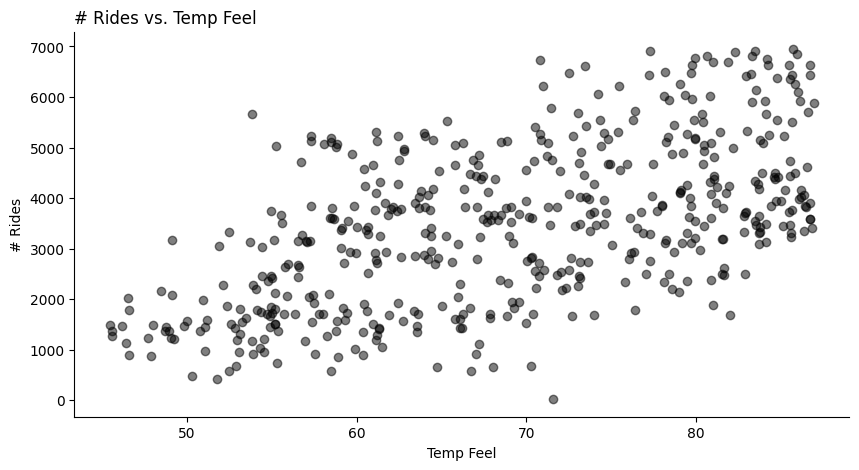

In [14]:
_, ax = plt.subplots(figsize=(10,5))
ax.scatter(data.temp_feel, data.rides, color="black", alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "# Rides vs. Temp Feel",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("Temp Feel");
ax.set_ylabel("# Rides");


In [6]:
def prior_func(
    mean_b0: float, std_b0: float, b0: Tensor,
    mean_b1: float, std_b1: float, b1: Tensor,
    rate_sigma: float, sigma: Tensor,
) -> Tensor:
    b0_log_prob = dist.Normal(mean_b0, std_b0).log_prob(b0)
    b1_log_prob = dist.Normal(mean_b1, std_b1).log_prob(b1)
    sigma_log_prob = dist.Exponential(rate=rate_sigma).log_prob(sigma)
    return (b0_log_prob + b1_log_prob + sigma_log_prob).squeeze()

def likelihood_func(b0: Tensor, b1: Tensor, sigma: Tensor, temp: Tensor, rides: Tensor) -> Tensor:
    # Check number of parameter samples
    assert (num_samples := len(b0)) == len(b1) == len(sigma)
    # Check number of data observations
    assert (num_obs := len(temp)) == len(rides)
    
    # Model, shape=(num_samples, num_obs)
    model = dist.Normal(b0 + b1 * temp[None, :], sigma)
    
    # Likelihood for each parameter set (agregated across iid observations)
    like = model.log_prob(rides[None, :]).sum(-1)
    
    return like

parameter_samples = ParameterSamples.random_initialization(
    bounds=dict(
        b0=(-5_000., 10_000.),
        b1=(-50., 300.),
        sigma=(1e-6, 10_000.)
    ),
    shapes=dict(b0=(1,), b1=(1,), sigma=(1,)),
    num_samples=2**13,
)

result = run_mcmc(
    parameter_samples,
    prior_func=partial(
        prior_func,
        mean_b0=-2_000, 
        std_b0=1_000,
        mean_b1=100, 
        std_b1=40,
        rate_sigma=0.0008,
    ),
    likelihood_func=partial(
        likelihood_func,
        temp=torch.from_numpy(data.temp_feel.values).to(torch.float32),
        rides=torch.from_numpy(data.rides.values).to(torch.float32),
    ),
    verbose=True,
)

result.get_posterior_summary()

,mean,std,min,25%,50%,75%,max
b0,-2136.285645,564.753296,-4946.486816,-2482.902649,-2154.171631,-1814.596039,2011.614502
b1,81.283691,8.080614,24.113178,76.680262,81.570534,86.226130,121.304459
sigma,1297.540161,64.665108,1103.697998,1255.419769,1291.346191,1330.836151,2074.290283


In [ ]:
_, ax = plt.subplots(figsize=(10,5))
for param in result.parameter_samples.keys():
    ax.plot(result.correlation_traces[param].squeeze(), label=param)
ax.set_title("Correlation of samples with intialization", loc="left");
ax.set_xlabel("MCMC Iteration #");
ax.set_ylabel("Correlation");
ax.spines[['right', 'top']].set_visible(False);
ax.legend();

In [ ]:
_, ax = plt.subplots(figsize=(10,5))
for param in result.parameter_samples.keys():
    ax.plot(result.wasserstein_distance_traces[param].squeeze(), label=param)
ax.set_title("Trace of Wasserstein distance between split A & B", loc="left");
ax.set_xlabel("MCMC Iteration #");
ax.set_ylabel("Wasserstein Distance");
ax.spines[['right', 'top']].set_visible(False);
ax.legend();

# Sequential Inference

In [18]:
ridxs = torch.randint(low=0, high=len(data), size=(100,))
idxs_1 = ridxs[:50]
idxs_2 = ridxs[50:]

parameter_samples = ParameterSamples.random_initialization(
    bounds=dict(
        b0=(-5_000., 10_000.),
        b1=(-50., 300.),
        sigma=(1e-6, 10_000.)
    ),
    shapes=dict(b0=(1,), b1=(1,), sigma=(1,)),
    num_samples=2**13,
)

In [19]:
result_1 = run_mcmc(
    parameter_samples,
    prior_func=partial(
        prior_func,
        mean_b0=-2_000, 
        std_b0=1_000,
        mean_b1=100, 
        std_b1=40,
        rate_sigma=0.0008,
    ),
    likelihood_func=partial(
        likelihood_func,
        temp=torch.from_numpy(data.temp_feel.values[idxs_1]).to(torch.float32),
        rides=torch.from_numpy(data.rides.values[idxs_1]).to(torch.float32),
    ),
    verbose=True,
)
result_1.get_posterior_summary()

,mean,std,min,25%,50%,75%,max
b0,-2723.989746,822.670593,-5000.000000,-3286.069702,-2726.340088,-2188.769714,342.024445
b1,89.559372,11.600941,38.483494,81.868883,89.610863,97.505926,125.624939
sigma,1416.069336,167.544922,992.266418,1304.847076,1401.955994,1508.030731,4894.348633


In [20]:
result_2 = run_mcmc(
    result_1.parameter_samples, # Start from posterior samples from 1
    prior_func=partial(
        prior_func,
        mean_b0=-2_000, 
        std_b0=1_000,
        mean_b1=100, 
        std_b1=40,
        rate_sigma=0.0008,
    ),
    likelihood_func=partial(
        likelihood_func,
        temp=torch.from_numpy(data.temp_feel.values[idxs_2]).to(torch.float32),
        rides=torch.from_numpy(data.rides.values[idxs_2]).to(torch.float32),
    ),
    verbose=True,
)
result_2.get_posterior_summary()

,mean,std,min,25%,50%,75%,max
b0,-2151.073975,753.127563,-5000.000000,-2662.048645,-2158.991577,-1644.921783,563.936646
b1,81.206642,10.542070,41.451042,74.224052,81.355267,88.291792,122.629898
sigma,1415.882812,144.092926,973.146118,1313.922760,1403.225159,1503.548737,2155.580322


In [21]:
result_1n2 = run_mcmc(
    parameter_samples, 
    prior_func=partial(
        prior_func,
        mean_b0=-2_000, 
        std_b0=1_000,
        mean_b1=100, 
        std_b1=40,
        rate_sigma=0.0008,
    ),
    likelihood_func=partial(
        likelihood_func,
        temp=torch.from_numpy(data.temp_feel.values[ridxs]).to(torch.float32),
        rides=torch.from_numpy(data.rides.values[ridxs]).to(torch.float32),
    ),
    verbose=True,
)
result_1n2.get_posterior_summary()

,mean,std,min,25%,50%,75%,max
b0,-2559.865723,653.417358,-5000.000000,-2998.015686,-2562.353760,-2126.071655,30.270054
b1,86.972206,9.094235,51.834301,80.896940,86.989162,93.040993,120.420540
sigma,1397.469360,101.549568,1094.832886,1327.334351,1392.281555,1460.694336,2181.272217
